# Exploratory Data Analysis

## Libraries

In [2]:
# import other files
import sys

sys.path.append("..")

In [3]:
# common functions
from common import missing_data_check, plot_histograms
# fetch functions
from etl.fetch import *
# environment variables
from dotenv import load_dotenv
import os
# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
# working with data
import numpy as np
from collections import Counter
from itertools import chain
from sklearn.preprocessing import MinMaxScaler

## Consolidating Data

In [4]:
# load environment variables
load_dotenv()

like_playlist_id = os.getenv("LIKE_PLAYLIST_ID")
dislike_playlist_id = os.getenv("DISLIKE_PLAYLIST_ID")

token = get_token()

'''
Personal playlist columns:
- artist_id, track_id, track_name, popularity, user_like
'''
like_playlist = get_playlist_tracks(token, like_playlist_id)
like_playlist['user_like'] = True
dislike_playlist = get_playlist_tracks(token, dislike_playlist_id)
dislike_playlist['user_like'] = False
songs = pd.concat([like_playlist, dislike_playlist])

'''
Track feature columns:
- 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
    'time_signature'
'''
track_ids = ','.join(songs.track_id.to_list())
track_features = get_track_features(token, track_ids).drop(columns=['analysis_url', 'track_href', 'type', 'uri'])

'''
Artist feature columns:
- 'artist_id', 'genres', 'name', 'popularity'
'''
artist_ids = ','.join(songs.artist_id.to_list())
artist_features = get_artist_attribute(token, artist_ids).drop(columns=['name', 'popularity'])

KeyError: 'access_token'

## Exploratory Analysis

In [5]:
missing_data_check(track_features)

,Total,Percent,Types
danceability,0,0.0,float64
energy,0,0.0,float64
key,0,0.0,int64
loudness,0,0.0,float64
mode,0,0.0,int64
speechiness,0,0.0,float64
acousticness,0,0.0,float64
instrumentalness,0,0.0,float64
liveness,0,0.0,float64
valence,0,0.0,float64


In [6]:
track_features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000
mean,0.605742,0.560021,5.092308,-8.075805,0.729808,0.070867,0.370100,0.038507,0.173375,0.487097,120.196335,197499.771154,3.899038
std,0.153354,0.232965,3.490829,4.301901,0.444273,0.071013,0.336314,0.149918,0.128702,0.230637,27.333089,51151.311071,0.351539
min,0.130000,0.000116,0.000000,-45.728000,0.000000,0.024400,0.000008,0.000000,0.026400,0.000000,54.747000,87000.000000,1.000000
25%,0.504000,0.394000,2.000000,-9.737750,0.000000,0.035475,0.050425,0.000000,0.095450,0.303750,100.009750,163715.500000,4.000000
50%,0.627000,0.564500,5.000000,-7.207500,1.000000,0.046500,0.266000,0.000007,0.118500,0.470000,120.007500,191852.000000,4.000000
75%,0.713000,0.756250,8.000000,-5.276000,1.000000,0.073425,0.694250,0.000870,0.209000,0.665000,138.213500,221888.750000,4.000000
max,0.970000,0.990000,11.000000,-1.540000,1.000000,0.676000,0.994000,0.973000,0.820000,0.967000,210.164000,740011.000000,5.000000


Checked to see if for any reason any of the tracks have missing audio features. This does not seem to be the case.

We note that:
- key is a categorical variable representing the key the track is in and can range from -1 to 11 (0 to 11 in our case)
- mode is binary and indicates the modality of a track (major or minor) where 1 is major and 0 is minor
- time_signature is an ordinal variable specifying the number of beats in each bar and can range from 3 to 7 (3 to 5 in our case)
- loudness, key, tempo, and duration_ms are continuous numerical variables that we can rescale to range from 0 and 1
- the rest of the variables are continuous numerical and are all already scaled between 0 and 1

In [7]:
# Normalization: X_new = (X — X_min)/ (X_max — X_min)
def normalize(df, features):
    for feature in features:
        df[feature] = (df[feature] - min(df[feature]))/(max(df[feature]) - min(df[feature]))

# normalize the continuous numerical features as mentioned
normalize(track_features, ['loudness', 'key', 'tempo', 'duration_ms'])

In [8]:
track_features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000
mean,0.605742,0.560021,0.462937,0.852091,0.729808,0.070867,0.370100,0.038507,0.173375,0.487097,0.421121,0.169216,3.899038
std,0.153354,0.232965,0.317348,0.097355,0.444273,0.071013,0.336314,0.149918,0.128702,0.230637,0.175869,0.078331,0.351539
min,0.130000,0.000116,0.000000,0.000000,0.000000,0.024400,0.000008,0.000000,0.026400,0.000000,0.000000,0.000000,1.000000
25%,0.504000,0.394000,0.181818,0.814480,0.000000,0.035475,0.050425,0.000000,0.095450,0.303750,0.291234,0.117480,4.000000
50%,0.627000,0.564500,0.454545,0.871741,1.000000,0.046500,0.266000,0.000007,0.118500,0.470000,0.419906,0.160567,4.000000
75%,0.713000,0.756250,0.727273,0.915452,1.000000,0.073425,0.694250,0.000870,0.209000,0.665000,0.537049,0.206564,4.000000
max,0.970000,0.990000,1.000000,1.000000,1.000000,0.676000,0.994000,0.973000,0.820000,0.967000,1.000000,1.000000,5.000000


In [9]:
songs.user_like.describe()

count      1040
unique        2
top       False
freq        826
Name: user_like, dtype: object

Of the 481 songs in the dataset, 284 are labelled dislike (59%) and 197 are labelled like (41%). This imbalance should be noted for later when the dataset is split into training/testing and during modelling as well.

In [10]:
def missing_genres_check(dataframe):
    data = dataframe.copy(deep=True)
    data['is_missing_genre'] = data.genres.astype(bool)    
    total = data.is_missing_genre[data.is_missing_genre == False].count()
    pct = (total / data.is_missing_genre.count()) * 100
    result = pd.DataFrame({'Total':total, 'Percent':pct}, index=['is_missing_genre'])
    return result

missing_genres_check(artist_features)

,Total,Percent
is_missing_genre,209,20.652174


We have that ~13% of the artists in my personal playlist are missing genres. This might be because these artists are not as well known and so Spotify has yet to assign them a genre.

An interesting observation is that genres are associated with an artist rather than a song. If I were to associate a song's genre(s) by its artist(s), this would mean that the song would belong to all of the genres of all of the participating artists. This assumption may cause problems when a particular artist has multiple genres that are vastly different but I will proceed this way for simplicity's sake.

In [11]:
# Drop artists with no genres assigned
artist_features = artist_features[artist_features['genres'].apply(len) > 0].reset_index(drop=True)

In [12]:
# Build final dataframe
df = songs.merge(track_features, how='inner', left_on='track_id', right_on='id').drop(columns=['id'])
# Split up artist(s) for each song
df_artists = df['artist_id'].str.split(',', expand=True)

In [13]:
# Create artist column for max number of artists associated with a song
for col in range(len(df_artists.columns)):
    df[f'artist_id{col}'] = df_artists[col]
df = df.drop(columns=['artist_id'])
# Join in genres on artist ids
for col in range(len(df_artists.columns)):
    df = df.merge(
            artist_features, how='left', left_on=f'artist_id{col}', right_on='artist_id'
            ).drop(
                columns=['artist_id', f'artist_id{col}']
                ).rename(
                    columns={'genres':f'genres{col}'}
                )
df = df.replace(np.nan, "")

Check the genres associated with each song...

In [14]:
genre_columns = [f'genres{i}' for i in range(len(df_artists.columns))]
columns = ['track_name']
columns.extend(genre_columns)
df[columns]

,track_name,genres0,genres1,genres2,genres3,genres4,genres5,genres6
0,get him back!,[pop],,,,,,
1,Afterlife,[alternative metal],,,,,,
2,Homemade Dynamite,"[art pop, metropopolis, nz pop, pop]",,,,,,
3,love is embarrassing,[pop],,,,,,
4,traitor,[pop],,,,,,
...,...,...,...,...,...,...,...,...
1035,Video Games,"[queer country, strut]",,,,,,
1036,Okay (Stereo),,,,,,,
1037,Bang!,[pov: indie],,,,,,
1038,Yes I'm A Mess,[pov: indie],,,,,,


In [15]:
# Merge lists of genres across columns
def combine_lists(row):
    combined_list = []
    for col in row:
        if len(col) > 0:
            combined_list.extend(col)
    return list(set(combined_list))

# Combine genres columns
df['genres'] = df[genre_columns].apply(combine_lists, axis=1)
df = df.drop(columns=genre_columns)


In [16]:
# Check missing genre distribution amongst like and dislike songs
missing_genres_like_songs = len(df[(df.user_like == True) & (df.genres.apply(len) == 0)])
missing_genres_dislike_songs = len(df[(df.user_like == False) & (df.genres.apply(len) == 0)])
print(f"Like songs: {missing_genres_like_songs}, Dislike songs: {missing_genres_dislike_songs}")

Like songs: 15, Dislike songs: 144


Considering only 7% of my like songs are missing genres and around 17.5% of my dislike songs are missing genres, I decide to remove songs with no genres from the dataset. Although I end up with a smaller dataset, this deletion lessens the effects of my imbalanced data class distribution.

In [17]:
# Drop songs with no genres
df = df[df.genres.apply(len) > 0].reset_index(drop=True)

Now visualizing the audio features of songs that I like vs. songs that I do not like...

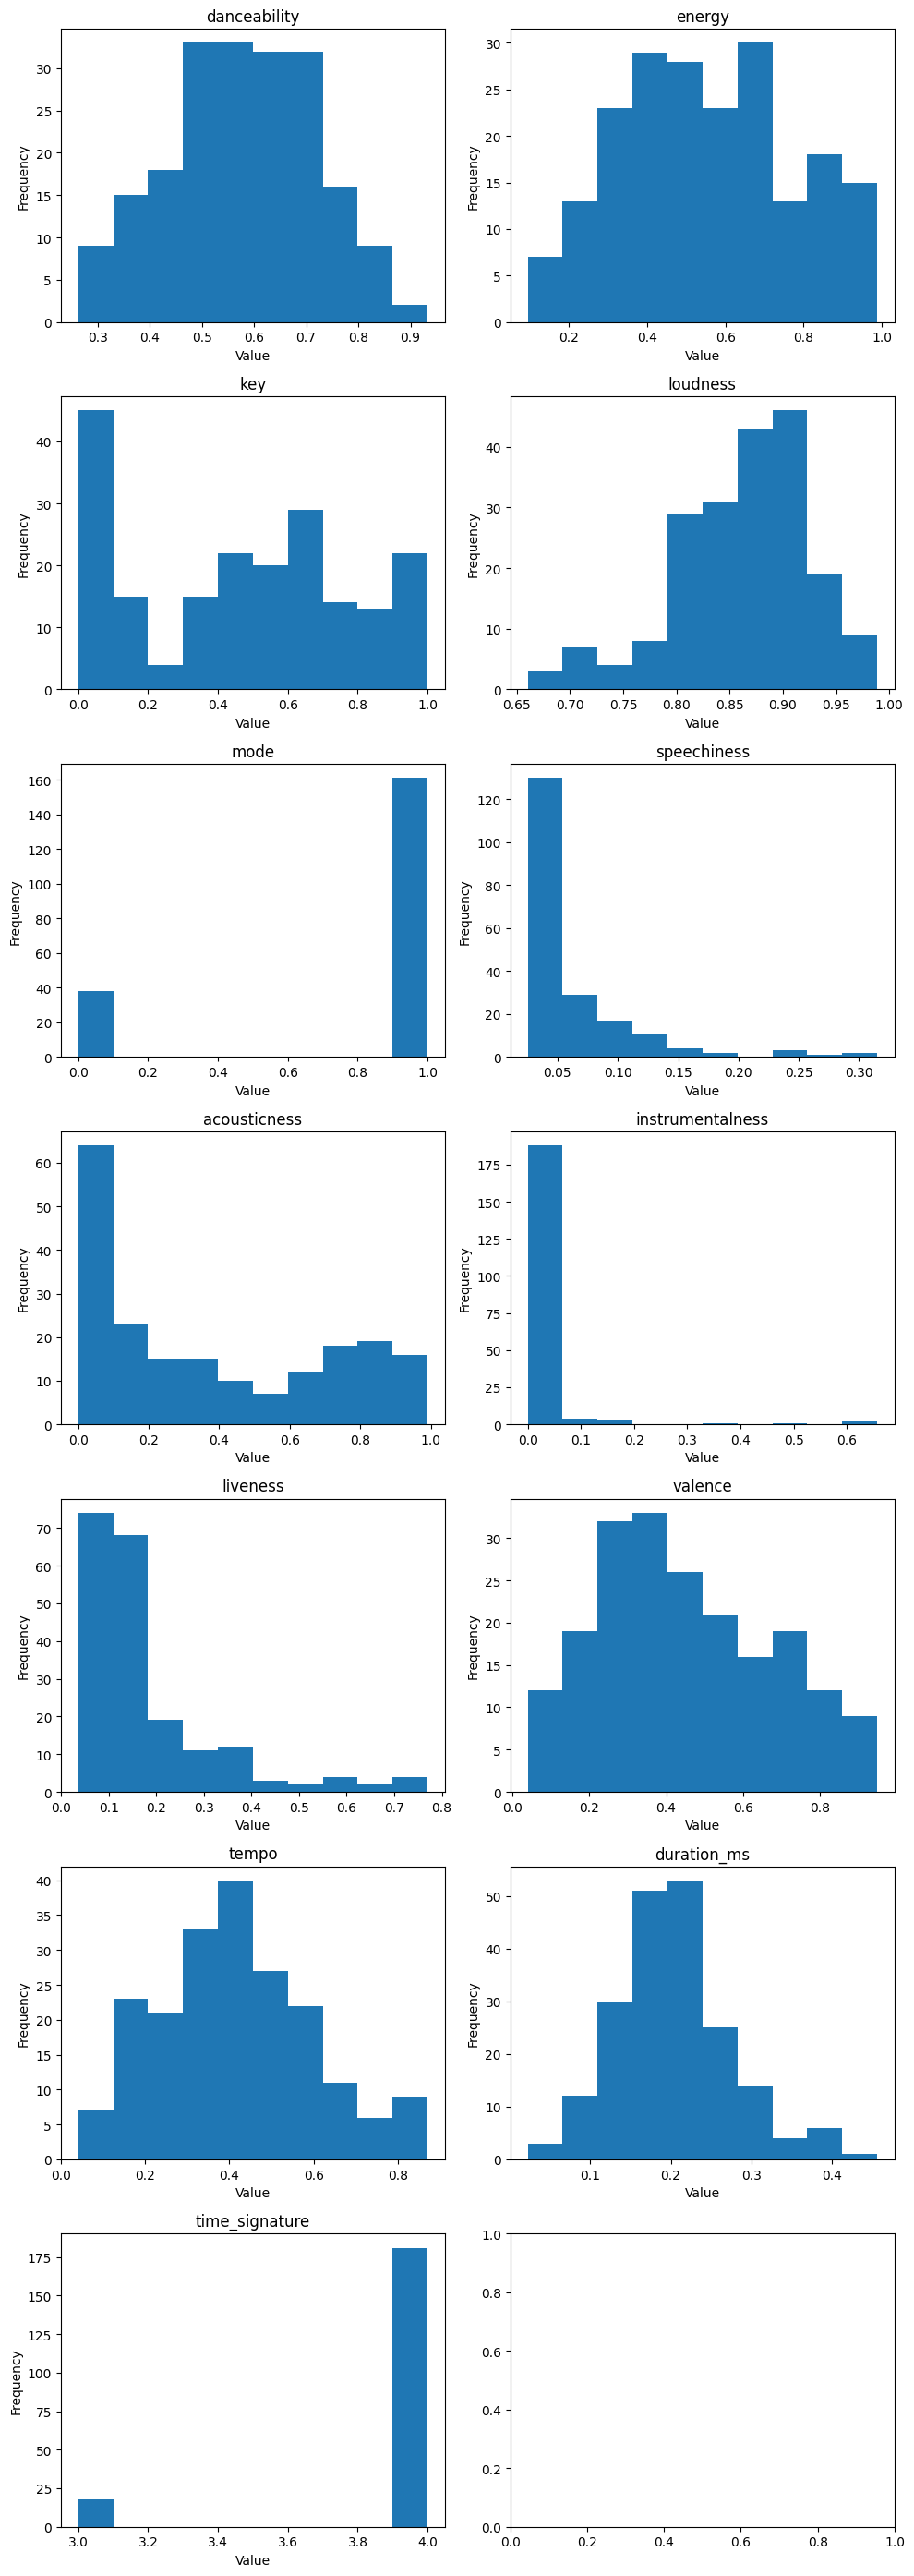

In [18]:
# TODO: data visualization on distribution of audio features
# TODO: data visualization on distribution of genres

features = df[df.user_like == True][['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

plot_histograms(features)

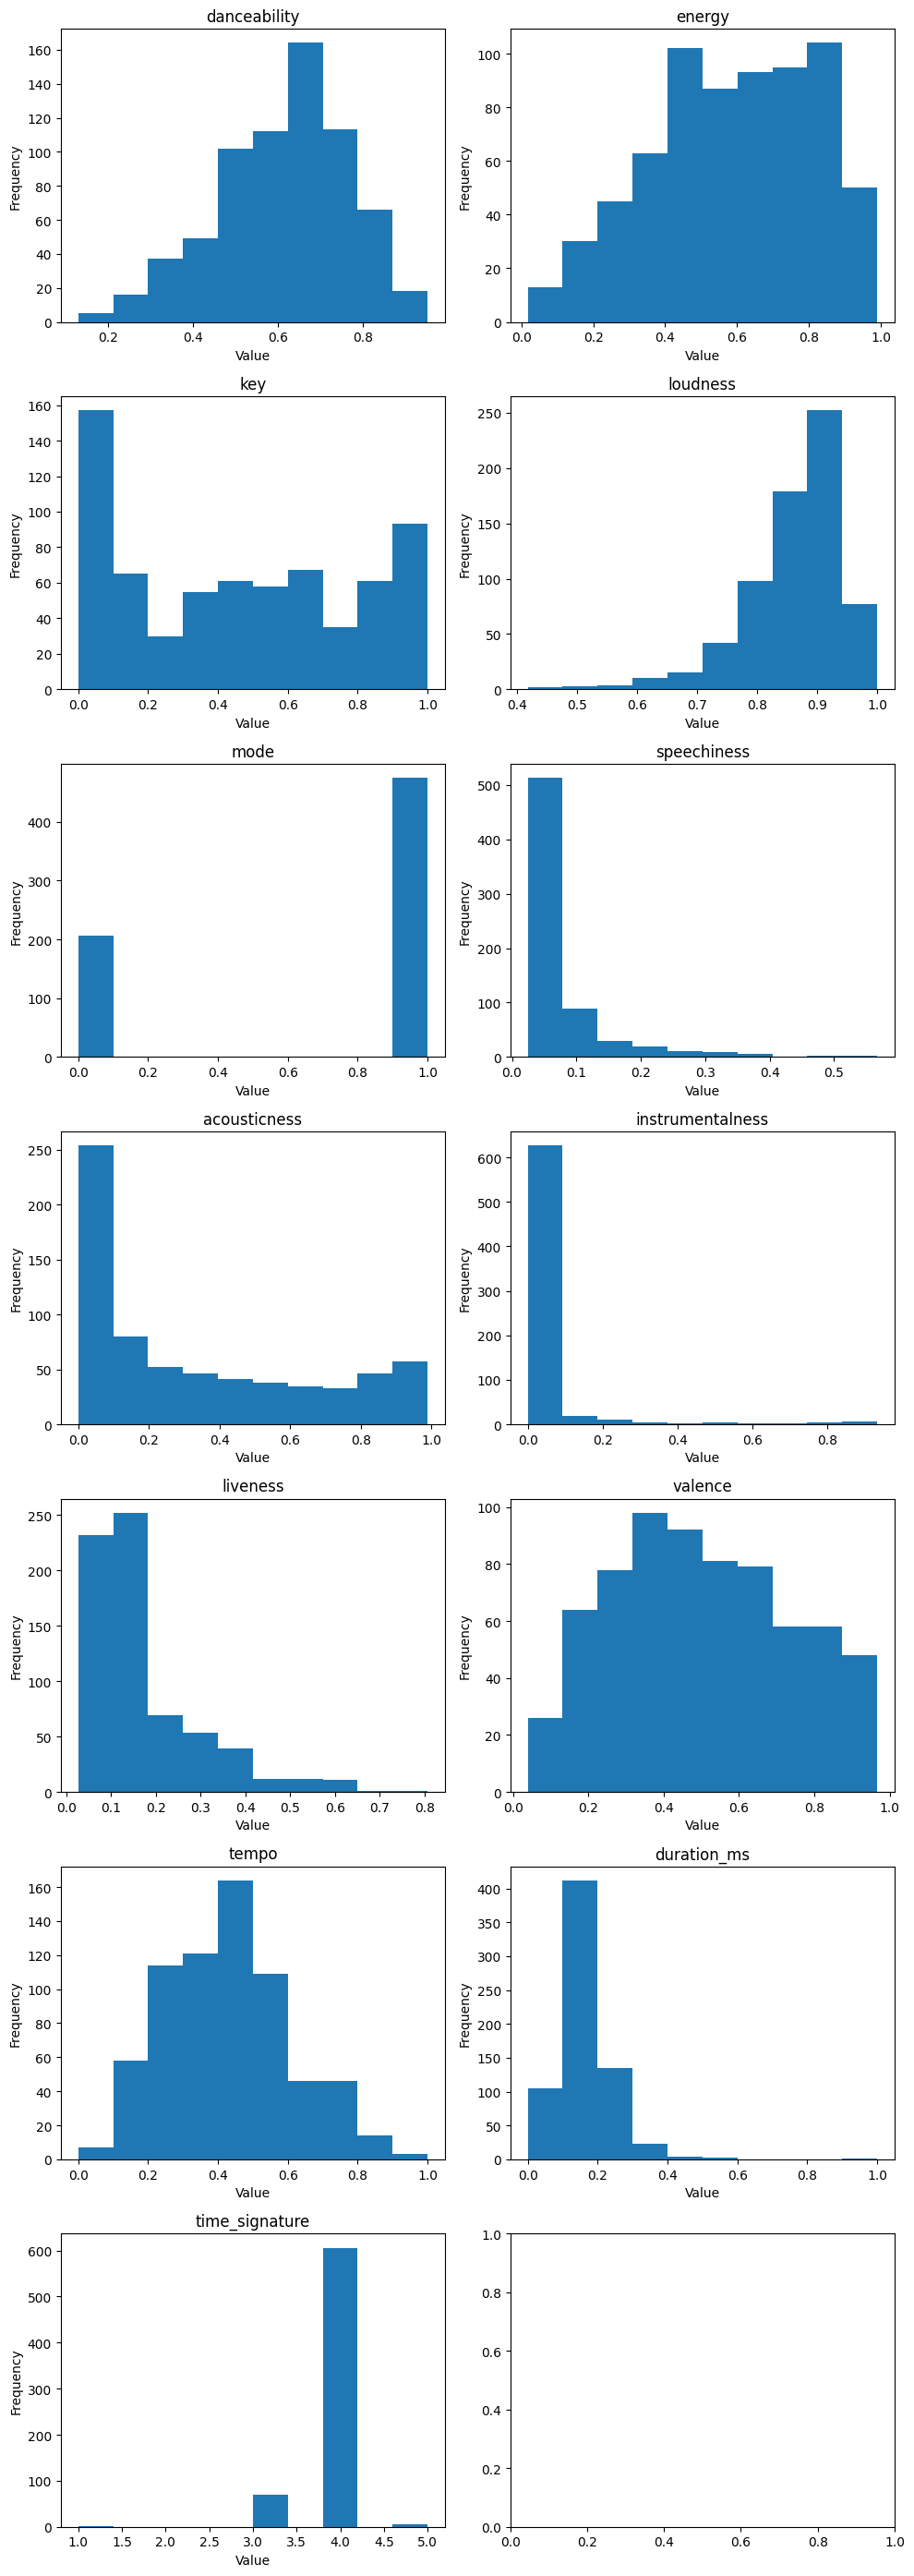

In [19]:
features = df[df.user_like == False][['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

plot_histograms(features)

There are 481 songs in total, 197 liked songs and 284 disliked songs. 

Summary of exploratory analysis on audio features:
- Songs that I dislike are on average: 
    - higher in danceability and energy
    - similar in loudness but skewed left heavier (i.e. some songs are a lot louder)
- Other audio features, based on visual inspection, are either similar or have negligible differences


In [20]:
like_genres = df[df.user_like == True]['genres'].explode().value_counts().reset_index()
like_genres.columns = ['Genre', 'Frequency']
dislike_genres = df[df.user_like == False]['genres'].explode().value_counts().reset_index()
dislike_genres.columns = ['Genre', 'Frequency']


In [21]:
like_most_freq_genre = like_genres[like_genres.Frequency == max(like_genres.Frequency)]
like_least_freq_genre = like_genres[like_genres.Frequency == min(like_genres.Frequency)]
dislike_most_freq_genre = dislike_genres[dislike_genres.Frequency == max(dislike_genres.Frequency)]
dislike_least_freq_genre = dislike_genres[dislike_genres.Frequency == min(dislike_genres.Frequency)]

In [38]:
like_songs_sparse_genre = round(like_genres[like_genres.Frequency == 1].shape[0] / like_genres.shape[0] * 100, 2)
dislike_songs_sparse_genre = round(dislike_genres[dislike_genres.Frequency == 1].shape[0] / dislike_genres.shape[0] * 100, 2)

res = pd.DataFrame({'Sparsity_Percent': [like_songs_sparse_genre, dislike_songs_sparse_genre]}, index=['Like_Songs', 'Dislike_Songs'])
res

,Sparsity_Percent
Like_Songs,55.70
Dislike_Songs,51.53


Considering around half of the genres of both like and dislike songs are sparse, it might be beneficial to group similar genres together.

In [80]:
exploded_genres = pd.DataFrame(df['genres'].explode()).reset_index()
exploded_genres.columns = ['idx', 'genre']

In [85]:
# exploded_genres[exploded_genres['genre'].apply(lambda f: f.find('pop') != -1)]
set(exploded_genres[exploded_genres['genre'].apply(lambda f: f.find('pop') != -1)]['genre'])

{'acoustic pop',
 'alternative pop rock',
 'ambient pop',
 'art pop',
 'australian alternative pop',
 'australian electropop',
 'australian pop',
 'austrian pop',
 'barbadian pop',
 'baroque pop',
 'bedroom pop',
 'brill building pop',
 'britpop',
 'bubblegum pop',
 'canadian electropop',
 'canadian pop',
 'canadian pop punk',
 'candy pop',
 'chamber pop',
 'chill pop',
 'colombian pop',
 'country pop',
 'dance pop',
 'dark pop',
 'desi pop',
 'dream pop',
 'electro-pop francais',
 'electropop',
 'etherpop',
 'europop',
 'folk-pop',
 'french pop',
 'gauze pop',
 'german pop',
 'hip pop',
 'hyperpop',
 'indie electropop',
 'indie fuzzpop',
 'indie pop',
 'indie poptimism',
 'irish pop',
 'italian pop',
 'jazz pop',
 'k-pop',
 'k-pop boy group',
 'k-pop girl group',
 'korean city pop',
 'korean dream pop',
 'korean electropop',
 'korean pop',
 'la pop',
 'latin pop',
 'metropopolis',
 'modern alternative pop',
 'modern country pop',
 'modern dream pop',
 'modern indie pop',
 'modern powe

In [188]:
like_most_freq_genre, dislike_most_freq_genre

(  Genre  Frequency
 0   pop         59,
         Genre  Frequency
 0  pov: indie        123)

In [43]:
like_least_freq_genre, dislike_least_freq_genre

(                     Genre  Frequency
 69              dance rock          1
 70                new wave          1
 71                    soul          1
 72            new romantic          1
 73               pop dance          1
 ..                     ...        ...
 135     italian soundtrack          1
 136       psychedelic rock          1
 137              folk rock          1
 138  charlottesville indie          1
 139       stomp and holler          1
 
 [71 rows x 2 columns],
                           Genre  Frequency
 117  christian alternative rock          1
 118               soulful house          1
 119                pop nacional          1
 120                  deep house          1
 121                         ccm          1
 ..                          ...        ...
 296                     norteno          1
 297         musica chihuahuense          1
 298              reggaeton flow          1
 299               pop reggaeton          1
 300             chris

In [46]:
missing_genres_check(df[df.user_like == True]), missing_genres_check(df[df.user_like == False])

(                  Total   Percent
 is_missing_genre     11  5.583756,
                   Total   Percent
 is_missing_genre     23  8.098592)

Of the 482 songs in total, 34 songs are missing genres where 11 are liked songs and 23 are disliked songs.

Of the liked songs the pop genre is the most frequent. In fact, 60 songs are considered pop songs making up ~30% of all liked songs. On the otherhand, 71 genres amongst liked songs are only assigned to one song.

Of the disliked songs the pop genre is also the most frequent. 69 songs are considered pop songs making up ~24% of all disliked songs and 184 genres only have one song associated with them.

Judging from the sparsity of genres, this may indicate that genres, at least in how I attributed them to each song, may not be a very useful feature to include. I'll keep this in mind as I build my models.

## Write To CSV

In [47]:
# relabelling for model building
df.user_like.replace({True: 1, False: 0}, inplace=True)
df.to_csv("songs.csv", index=False)